In [13]:
# DO NOT RUN THIS CEL!!! 
#! pip install gplearn 
!git clone https://github.com/yanavdsande/gplearn.git
!pip install ./gplearn

fatal: destination path 'gplearn' already exists and is not an empty directory.


Processing c:\users\yanas\onedrive\masters\untitled folder 1\gplearn
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for gplearn: filename=gplearn-0.5.dev0-py3-none-any.whl size=25974 sha256=162fa5f910a77361a2137350ba154a1262b3c6a107bb35aca86345c90aa80ced
  Stored in directory: C:\Users\yanas\AppData\Local\Temp\pip-ephem-wheel-cache-kulmkc3e\wheels\6e\0e\1a\888b3ff1f0470d777e7f3abe875319a43034b079ca45b15c42
Successfully built gplearn
  Attempting uninstall: gplearn
    Found existing installation: gplearn 0.5.dev0
    Uninstalling gplearn-0.5.dev0:
      Successfully uninstalled gplearn-0.5.dev0


You should consider upgrading via the 'c:\users\yanas\appdata\local\continuum\anaconda3\python.exe -m pip install --upgrade pip' command.


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from gplearn.genetic import SymbolicRegressor
from gplearn.functions import make_function
from gplearn.fitness import make_fitness
import math
import sys
import graphviz
from sklearn.utils.random import check_random_state
from sklearn.metrics import mean_squared_error

In [15]:
data = [(-1, 0), 
        (-0.9, -0.1629), 
        (-0.8, -0.2624), 
        (-0.7, -0.3129), 
        (-0.6, -0.3264), 
        (-0.5, -0.3125), 
        (-0.4, -0.2784), 
        (-0.3, -0.2289), 
        (-0.2, -0.1664), 
        (-0.1, -0.0909),
        (0, 0), 
        (0.1, 0.1111), 
        (0.2, 0.2496), 
        (0.3, 0.4251), 
        (0.4, 0.6496), 
        (0.5, 0.9375),
        (0.6, 1.3056), 
        (0.7, 1.7731), 
        (0.8, 2.3616), 
        (0.9, 3.0951), 
        (1, 4)]

X = np.array([x[0] for x in data]).reshape(-1, 1)
y = np.array([x[1] for x in data]).reshape(-1, 1)

#Borrowed from:
#https://github.com/trevorstephens/gplearn/issues/49
#(takes care of very high outputs of exp())
def expFunc(x1):
    with np.errstate(over='ignore'):
        return np.where(np.abs(x1) < 100, np.exp(x1), 0.)

exp = make_function(function=expFunc,name='exp', arity=1)

#Borrowed from:
#https://stackoverflow.com/questions/52560845/what-is-the-fastest-way-to-calculate-sum-of-absolute-differences-between-two-ima
def sumOfAbsoluteErrorsFunc(y_prediction, y_outcome, w):
    difference = np.subtract(y_prediction,y_outcome,dtype=float)
    absolute = np.abs(difference)
    return np.sum(absolute)
    
sumOfAbsoluteErrors = make_fitness(sumOfAbsoluteErrorsFunc, greater_is_better = False)

In [16]:
gp = SymbolicRegressor(population_size=1000, 
                       generations=50, 
                       p_crossover=0.7, 
                       function_set=['add', 'sub', 'mul', 'log', exp, 'sin', 'cos', 'div'], 
                       #I did not know for sure what type of mutation was referred to in in the assignment.
                       #Namely, gplearn provides three types of mutation. I based my choice off of the 
                       #information provided during the second lecture.
                       p_subtree_mutation = 0,
                       metric=sumOfAbsoluteErrors, verbose=1)

gp.fit(X, y.ravel())
gp.score(X, y.ravel())
print(gp)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    15.43      2.87999e+32        6          7.94333              N/A     42.28s
   1    10.64      1.33976e+16        5           5.2503              N/A     50.62s
   2     9.60          17.0207       13          3.63414              N/A     47.84s
   3    12.19      3.87715e+08       13          3.34889              N/A     31.11s
   4    10.01           122120       22          2.18642              N/A     33.60s
   5    10.96      2.55621e+23       24          1.77869              N/A     27.11s
   6    14.34       1.8632e+26       22          1.74243              N/A     28.02s
   7    17.64      5.49641e+08       29          1.64479              N/A     37.37s
   8    17.99          13.2321       23          1.50709              N/A  

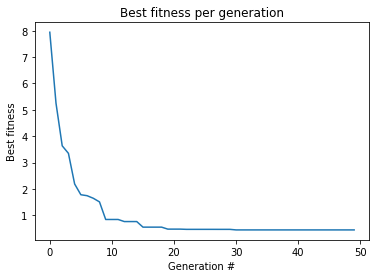

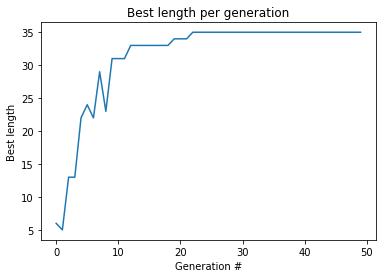

 "The length of a program is the number of elements in the formula which is equal to the total number of nodes".


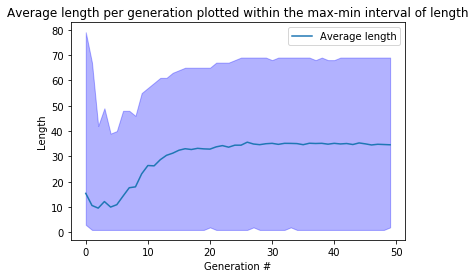

In [17]:
plt.title("Best fitness per generation")
plt.plot(gp.run_details_['generation'], gp.run_details_['best_fitness'])
plt.ylabel("Best fitness")
plt.xlabel("Generation #")
plt.show()

plt.title("Best length per generation")
plt.plot(gp.run_details_['generation'], gp.run_details_['best_length'])
plt.ylabel("Best length")
plt.xlabel("Generation #")
#txt=" \"The length of a program is the number of elements in the formula which is equal to the total number of nodes.\" "
#plt.figtext(1, -0.3, txt, wrap=True, horizontalalignment='right', fontsize=12)
plt.show()
print(" \"The length of a program is the number of elements in the formula which is equal to the total number of nodes\".")

fig, ax = plt.subplots()
plt.title("Average length per generation plotted within the max-min interval of length")
plt.plot(gp.run_details_['generation'], gp.run_details_['average_length'])
ax.fill_between(gp.run_details_['generation'], gp.run_details_['min_length'], gp.run_details_['max_length'], color='b', alpha=.3)         
plt.ylabel("Length")
plt.xlabel("Generation #")
plt.legend(['Average length'])
plt.show()



**Can you observe any undesirable phenomenon from these plots?**

The average length per generation grows while the best fitness stagnates; bloating occurs.

**In case of positive answer, how would you try to overcome the related problem? (You can refer to - and briefly describe - a specific paper from the literature)**

The fitness measure could be penalized, so the fitness of an individual could be adjusted based on its size. This way, the larger problems would be discarded more quickly. This method, introduced by Poli & Mcphee (2008) is called the covariant parsimony method.

Poli, Riccardo & Mcphee, Nicholas. (2008). Covariant Parsimony Pressure for Genetic Programming. 